# Семинар по обработке звука - 1

https://colab.research.google.com/drive/1G97XqNom5n2TCqCB7SmLkYoQ9GKGv0XK?usp=sharing

В этом семинаре мы сделаем следующие вещи:

    - Напишем обработку данных для обучения модели по распознаванию речи
    - Напишем простенькую модель
    - Обучим модель с помощью функции потерь CTC
    - Замерим качество с помощью такиx метрик как CER

In [ ]:
!pip install  torchaudio==0.7.2

     |████████████████████████████████| 7.6 MB 4.3 MB/s 
     |████████████████████████████████| 776.8 MB 18 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.10.0+cu111
    Uninstalling torchaudio-0.10.0+cu111:
      Successfully uninstalled torchaudio-0.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.7.1 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.7.1 which is incompatible.


In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!mkdir data
#!python gfile.py -u https://drive.google.com/file/d/1HKtLLbiEk0c3l1mKz9LUXRAmKd3DvD0P \
#    -f "numbers.zip" \
#    -d data/

# Скачайте архив numbers.zip по ссылке
# https://drive.google.com/file/d/1HKtLLbiEk0c3l1mKz9LUXRAmKd3DvD0P
# и загрузите его на гугл диск, например, путь
# '/content/drive/MyDrive/Colab Notebooks/sem06_QuarzNet/numbers.zip'
!cp '/content/drive/MyDrive/Colab Notebooks/sem06_QuarzNet/numbers.zip' numbers.zip

!unzip numbers.zip -d data/

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchaudio
from IPython import display
from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset

assert torch.__version__.startswith("1.7.1")
assert torchaudio.__version__ == "0.7.2"

/usr/local/lib/python3.7/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


# Данные

Это датасет с числами от 0 до 999_999 произнесенный на русском языке

Тут есть разные спикеры разного возраста и пола

In [ ]:
!wget https://raw.githubusercontent.com/markovka17/digit-recognition/master/gfile.py

--2022-03-02 21:15:59--  https://raw.githubusercontent.com/markovka17/digit-recognition/master/gfile.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3422 (3.3K) [text/plain]
Saving to: ‘gfile.py’

gfile.py            100%[===================>]   3.34K  --.-KB/s    in 0s      

2022-03-02 21:15:59 (44.3 MB/s) - ‘gfile.py’ saved [3422/3422]



Переводим все аудио к одинаковому sample_rate=16000, а ответы - к нужному нам виду. 

Например, если произносится число 123, то приводим ответ к виду: y = [1,2,3]

In [ ]:
import os

import numpy as np
import pandas as pd


class SpeechDataset(Dataset):

    SAMPLE_RATE = 16000
    _ROOT_PREFIX = "data/numbers"

    def __init__(self, path_to_csv: str):
        self.path_to_csv = path_to_csv

        self.csv: pd.DataFrame = pd.read_csv(path_to_csv)

    @staticmethod
    def number2digits(number: np.ndarray) -> torch.Tensor:
        digits = list(map(int, list(str(number))))
        return torch.LongTensor(digits)

    def __getitem__(self, index: int):
        output = self.csv.iloc[index]

        if len(output) == 3:
            path, gender, number = output
            y = self.number2digits(number)
        else:
            (path,) = output
            y = torch.LongTensor([-1])

        path = os.path.join(self._ROOT_PREFIX, path)

        wav, sr = torchaudio.load(path)
        if sr != self.SAMPLE_RATE:
            resampler = torchaudio.transforms.Resample(sr, self.SAMPLE_RATE)
            wav = resampler(wav)

        wav = wav.squeeze()

        instance = {"path": path, "x": wav, "y": y}

        return instance

    def __len__(self):
        return self.csv.shape[0]

In [ ]:
dataset = SpeechDataset("data/numbers/train.csv")

train_ratio = 0.9
train_size = int(len(dataset) * train_ratio)

random_indexes = torch.randperm(len(dataset)).tolist()
train_dataset = Subset(dataset, random_indexes[:train_size])
val_dataset = Subset(dataset, random_indexes[train_size:])

In [ ]:
len(train_dataset), len(val_dataset)

(8100, 900)

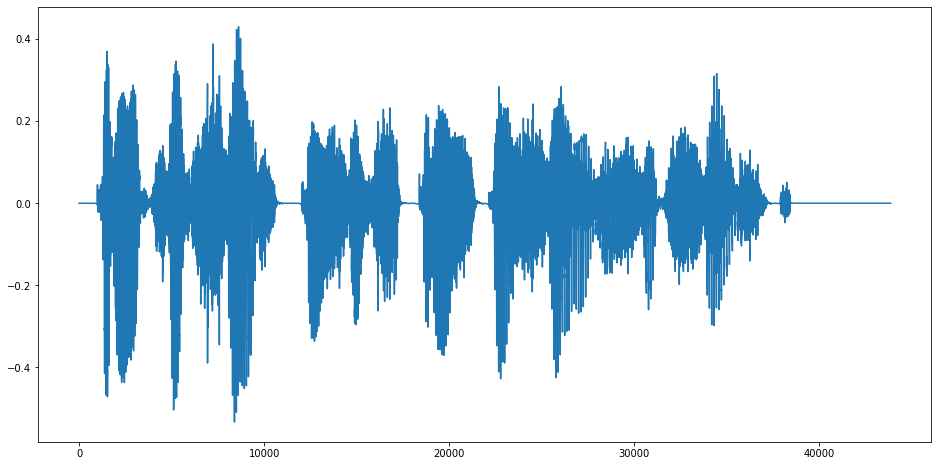

In [ ]:
instance = train_dataset[0]
plt.figure(figsize=(16, 8))
plt.plot(instance["x"])

display.Audio(instance["x"], rate=dataset.SAMPLE_RATE)

In [ ]:
instance["y"]

tensor([3, 6, 3, 7, 6])

Делаем паддинг: в датасете числа от 0 до 999999. Для работы с датасетом нам удобно, чтобы все ответы y были одинаковой длины. Если число короче шести знаков, то оставшиеся ячейки заполняем '10':

123456 -> y = [1,2,3,4,5,6]

123    -> y = [1,2,3,10,10,10]

In [ ]:
from itertools import islice

from tqdm import tqdm


class PaddingCollator:
    def __call__(self, instances):
        batch_size = len(instances)
        x_len = torch.LongTensor([instance["x"].size(0) for instance in instances])
        y_len = torch.LongTensor([instance["y"].size(0) for instance in instances])
        path = [instance["path"] for instance in instances]

        x = torch.zeros(batch_size, max(x_len), dtype=torch.float32)
        y = torch.zeros(batch_size, max(y_len), dtype=torch.long)
        y.fill_(10)  # 10 -- паддинг

        for i, instance in enumerate(instances):
            x[i, : x_len[i]] = instance["x"]
            y[i, : y_len[i]] = instance["y"]

        instance = {"x": x, "y": y, "x_len": x_len, "y_len": y_len, "path": path}

        return instance

In [ ]:
train_dataloader = DataLoader(
    train_dataset,
    64,
    collate_fn=PaddingCollator(),
    shuffle=True,
    pin_memory=True,
    drop_last=True,
)
val_dataloader = DataLoader(
    val_dataset, 32, collate_fn=PaddingCollator(), pin_memory=True
)

In [ ]:
batch = list(islice(val_dataloader, 1))[0]
batch

{'path': ['data/numbers/train/09570551fe.wav',
  'data/numbers/train/8d81e5e50e.wav',
  'data/numbers/train/ccafd0695b.wav',
  'data/numbers/train/63385ba356.wav',
  'data/numbers/train/eabd1a420b.wav',
  'data/numbers/train/9ae836ea5e.wav',
  'data/numbers/train/d32b0f432b.wav',
  'data/numbers/train/436826dc72.wav',
  'data/numbers/train/992e0e5ff5.wav',
  'data/numbers/train/1a7ca76132.wav',
  'data/numbers/train/cee2974506.wav',
  'data/numbers/train/f04509dcac.wav',
  'data/numbers/train/e51a852ead.wav',
  'data/numbers/train/9595e7d3eb.wav',
  'data/numbers/train/692db44f44.wav',
  'data/numbers/train/5c39307063.wav',
  'data/numbers/train/67709f9b60.wav',
  'data/numbers/train/2396ce97b8.wav',
  'data/numbers/train/185889f672.wav',
  'data/numbers/train/8159fc2213.wav',
  'data/numbers/train/f529ac4682.wav',
  'data/numbers/train/ea766c11a3.wav',
  'data/numbers/train/33dc275ed4.wav',
  'data/numbers/train/1651f2096b.wav',
  'data/numbers/train/b15cc01842.wav',
  'data/numbers/t

# Вычисление признаков

**Идея**: нарезаем сигнал на кусочки, и для каждого кусочка делаем преобразование Фурье и вычисляем его Мел-спектрограмму.

Подробнее:

1. О преобразовании Фурье: https://proglib.io/p/fourier-transform/

2. Нарезаем сигнал на кусочки:

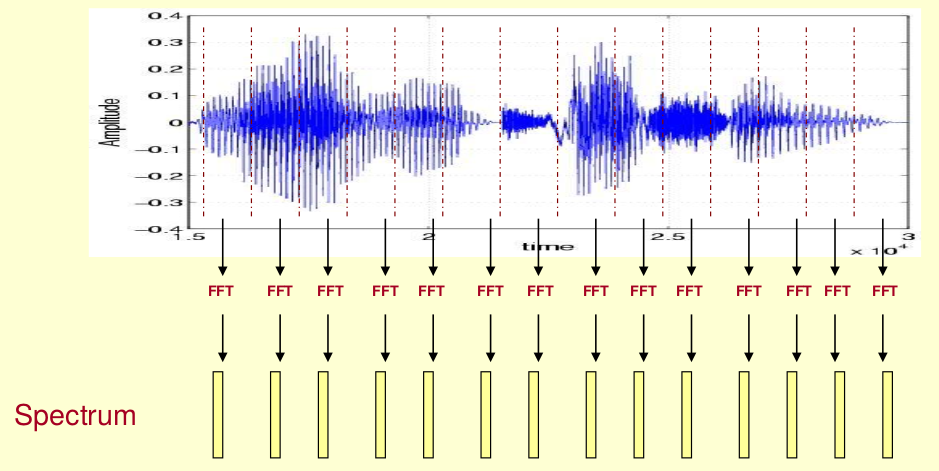

3. Для каждого кусочка получаем спектрограмму, и затем - Мел-спектрограмму.


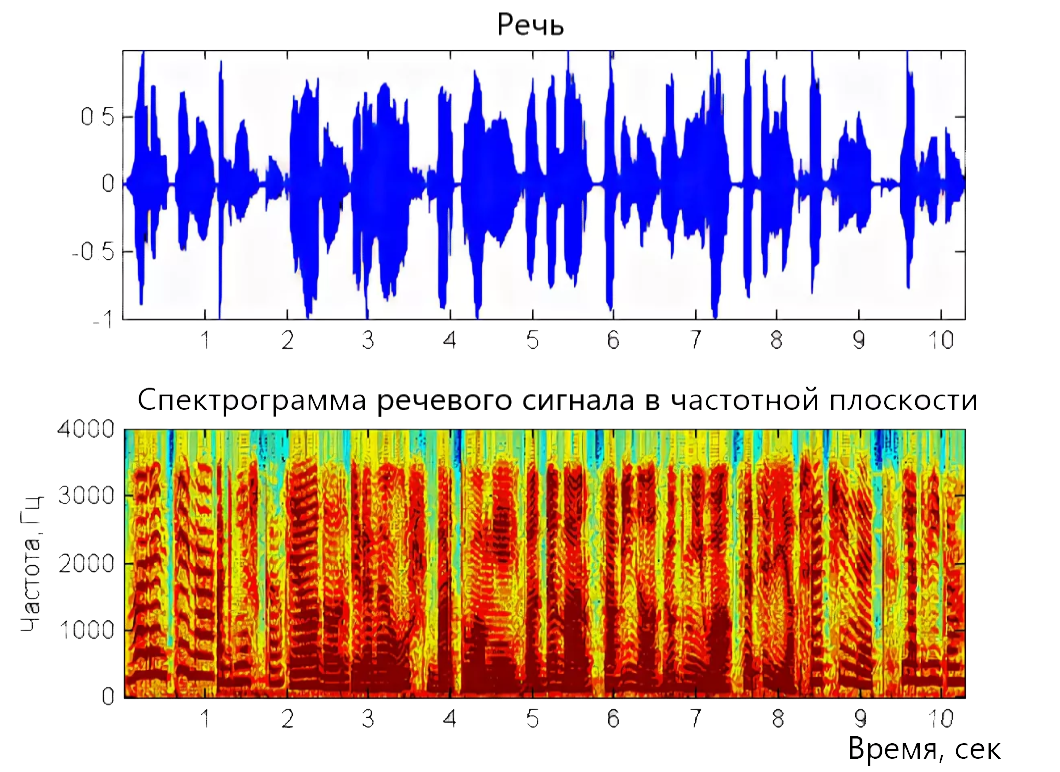

Пример получения спектрограммы по сигналу: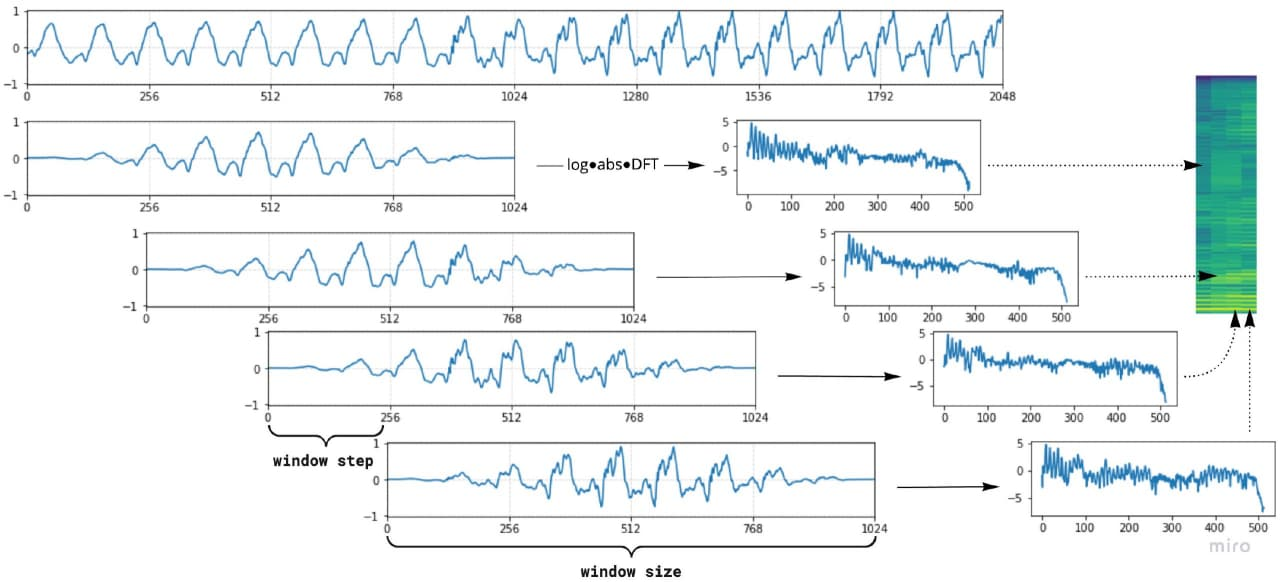

In [ ]:
instance = train_dataset[31]
wav = instance["x"]

In [ ]:
from torchaudio.transforms import MelSpectrogram

Подробнее о параметрах Мел-спектрограммы: https://rdrr.io/cran/torchaudio/man/transform_mel_spectrogram.html

In [ ]:
featurizer = MelSpectrogram(
    sample_rate=train_dataset.dataset.SAMPLE_RATE,
    n_fft=512,
    win_length=512,
    hop_length=512,
    n_mels=64,
    power=1,
)


def apply_compression(melspec):
    # Добавляем eps=1e-7 чтобы избежать log(0)
    return torch.log(melspec.clamp(1e-5))

/usr/local/lib/python3.7/dist-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/usr/local/lib/python3.7/dist-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


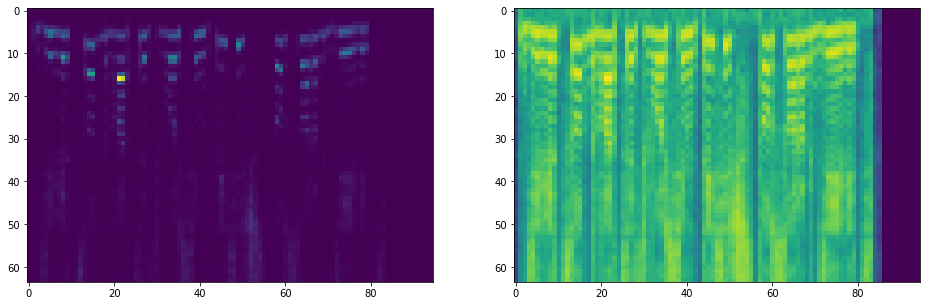

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(featurizer(wav))
axes[1].imshow(apply_compression(featurizer(wav)))

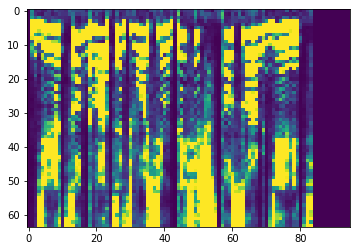

In [ ]:
# Аугментация Мел-спектрограммы
effects = [
    ["gain", "-n"],  # normalises to 0dB
    ["pitch", "5"],  # 5 cent pitch shift
]
waveform, sample_rate = torchaudio.sox_effects.apply_effects_tensor(
    featurizer(wav).cpu(), 16000, effects, channels_first=True
)
plt.imshow(waveform)

In [ ]:
class Featurizer(nn.Module):
    def __init__(self):
        super().__init__()

        self.featurizer = MelSpectrogram(
            sample_rate=train_dataset.dataset.SAMPLE_RATE,
            n_fft=512,
            win_length=512,
            hop_length=512,
            n_mels=64,
            power=1,
        )

    def forward(self, x, x_len=None):
        x = self.featurizer(x)
        x = apply_compression(x)

        # Переводим длинну из wav размера в melSpec размер
        if x_len is not None:
            x_len = ((x_len + 1).float() / self.featurizer.hop_length).ceil().long()
            return x, x_len

        return x

## Модель

Напишем простую и маленькую модель на основе QuartzNet https://arxiv.org/pdf/1910.10261.pdf

In [ ]:
from torch import nn


class QuartzBlock(nn.Module):
    """
    Basic block of QuartzNet consisting of Separable Convolution, BatchNorm and ReLU repeating R times

    :param in_channels: number of input channels
    :param hidden_channels: number of hidden and output channels
    :param kernel_size: size of kernels
    :param repeat: number of repetitions of block constituents
    """

    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        kernel_size: int = 33,
        repeat: int = 4,
    ):
        super().__init__()

        self.repeat = repeat
        self.blocks = nn.ModuleList(
            [
                nn.ModuleList(
                    [
                        nn.Conv1d(
                            in_channels=in_channels if i == 0 else hidden_channels,
                            out_channels=hidden_channels,
                            kernel_size=kernel_size,
                            groups=in_channels if i == 0 else hidden_channels,
                            padding=kernel_size // 2,
                            bias=False,
                        ),
                        nn.Conv1d(
                            hidden_channels, hidden_channels, kernel_size=1, bias=False
                        ),
                        nn.BatchNorm1d(hidden_channels),
                        nn.ReLU(),
                        nn.Dropout(p=0.2, inplace=False),
                    ]
                )
                for i in range(repeat)
            ]
        )
        self.res_conv = nn.Sequential(  # convolution for residual
            nn.Conv1d(in_channels, hidden_channels, kernel_size=1, bias=False),
            nn.BatchNorm1d(hidden_channels),
        )

    def forward(self, x):
        x_initial = x

        for i, block in enumerate(self.blocks):
            for j, layer in enumerate(block):
                # If not last ReLU
                if not (i == (len(self.blocks) - 1) and j == (len(block) - 1)):
                    x = layer(x)
                else:
                    # Pass residual
                    x = x + self.res_conv(x_initial)
                    x = layer(x)
        return x

In [ ]:
class DummyModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()

        self.prenet = nn.Sequential(
            nn.Conv1d(
                in_channels, hidden_channels, 33, padding=33 // 2, stride=2, bias=False
            ),
            nn.Conv1d(hidden_channels, hidden_channels, kernel_size=1, bias=False),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(),
            nn.Dropout(p=0.2, inplace=False),
        )

        self.net = nn.Sequential(
            QuartzBlock(hidden_channels, hidden_channels),
            QuartzBlock(hidden_channels, hidden_channels * 2),
            nn.Conv1d(
                hidden_channels * 2,
                hidden_channels * 2,
                33,
                padding=33 // 2,
                stride=2,
                bias=False,
            ),
            nn.Conv1d(
                hidden_channels * 2, hidden_channels * 2, kernel_size=1, bias=False
            ),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(),
            QuartzBlock(hidden_channels * 2, hidden_channels * 4),
        )
        self.classifier = nn.Sequential(
            nn.Conv1d(hidden_channels * 4, out_channels, kernel_size=1, bias=False),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x, x_len):
        x = self.prenet(x)
        x = self.net(x)
        return self.classifier(x), x_len // 4


# DummyModel(64, 128, 10 + 1)

## Считаем CER (character error rate)

Пример вычисления аналогичной метрики, но по словам (WER, word error rate): https://www.rev.ai/blog/how-to-calculate-word-error-rate/

In [ ]:
!pip install Levenshtein

     |████████████████████████████████| 258 kB 4.8 MB/s 
     |████████████████████████████████| 2.1 MB 10.0 MB/s 


Для вычисления CTC-loss необходимо сделать предобработку предсказния: убрать повторяющиеся символы и blank-символы.

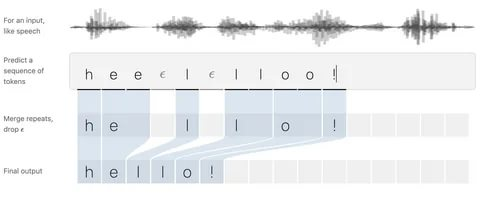

In [ ]:
import Levenshtein


def ctc_decode(sequence, black_symbol=10):
    """
    Декодируем гипотезы
        1) Убираем повторяющиеся буквы
        2) Удаляем blank символы
    """
    current = []
    for i in range(0, len(sequence)):
        symbol = sequence[i]

        if i > 0 and symbol == sequence[i - 1]:
            continue

        # skip blank symbol
        if symbol == black_symbol:
            continue

        current.append(str(int(symbol)))

    text = "".join(current)
    return text


def calculate_cer(targets, decodings, padding_value=10):
    """
    Считаем расстояние Левенштейна между предсказаниями и GT
    """

    cer = 0.0
    targets = targets.detach().cpu().tolist()

    pairs = []
    for target, d in zip(targets, decodings):
        target = [c for c in target if c != padding_value]
        target = "".join(map(str, target))

        decoding = ctc_decode(d.tolist())
        cer += min(1, Levenshtein.distance(target, decoding) / (len(decoding) + 1e-7))

        pairs.append(target + "\t\t" + decoding)

    return cer / len(target), pairs

## Обучение

In [ ]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
NUM_EPOCH = 20
DEVICE = torch.device("cuda:0")

model = DummyModel(64, 128, 10 + 1).to(DEVICE)
mel_featurizer = Featurizer().to(DEVICE)
criterion = nn.CTCLoss(blank=10)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

In [ ]:
from collections import defaultdict

from IPython import display

In [ ]:
history = defaultdict(list)

In [ ]:
import random

Epoch: 19
Example of prediction:  445091 -> 44509191238
Example of prediction:  856544 -> 85654452
Example of prediction:  77831 -> 778319238
Example of prediction:  538538 -> 53853873858
Example of prediction:  18859 -> 18859828


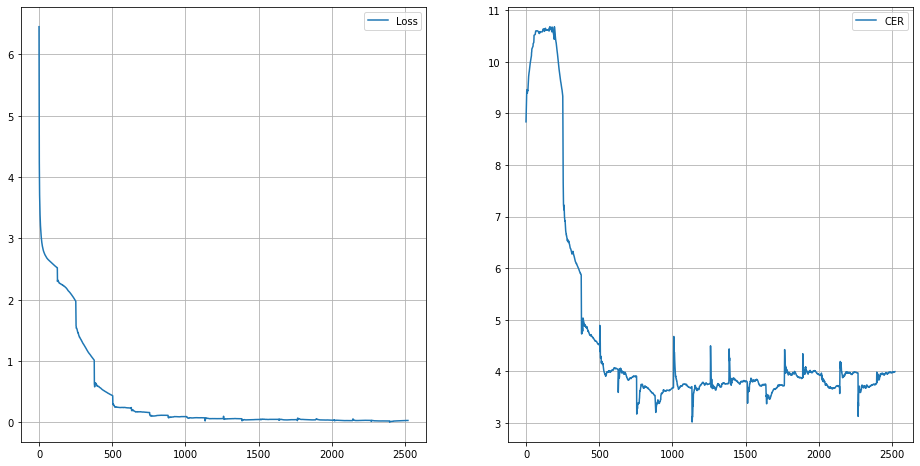

In [ ]:
effects = [
    ["gain", "-n"],  # normalises to 0dB
    ["pitch", "5"],  # 5 cent pitch shift
]

for epoch in range(NUM_EPOCH):

    average_cer = AverageMeter()
    average_loss = AverageMeter()

    for batch in train_dataloader:
        x = batch["x"].to(DEVICE)
        y = batch["y"].to(DEVICE)
        x_len = batch["x_len"].to(DEVICE)
        y_len = batch["y_len"].to(DEVICE)

        x, x_len = mel_featurizer(x, x_len)

        # здесь можно добавить аугментацию

        batch_size = x.shape[2]
        for i in range(batch_size // 2):
            if i % 2 == 0:
                # аугментация из torchaudio
                tmp, sample_rate = torchaudio.sox_effects.apply_effects_tensor(
                    x[:, :, i].cpu(), 16000, effects
                )
                x[:, :, i] = tmp.to(DEVICE)

        log_probs, x_len = model(x, x_len)

        # B, C, T -> T, B, C
        log_probs = log_probs.permute(2, 0, 1)
        loss = criterion(log_probs, y, x_len, y_len)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # T, B, C -> T, B -> B, T
        argmax_decoding = log_probs.detach().cpu().argmax(dim=-1).transpose(0, 1)

        cer, pairs = calculate_cer(y, argmax_decoding)

        average_cer.update(cer)
        average_loss.update(loss.item())

        history["loss"].append(average_loss.avg)
        history["cer"].append(average_cer.avg)

    display.clear_output()
    print(f"Epoch: {epoch}")
    for i in range(5):
        print(f"Example of prediction: ", pairs[i].replace("\t\t", " -> "))

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    axes[0].plot(history["loss"], label="Loss")
    axes[1].plot(history["cer"], label="CER")
    axes[0].legend()
    axes[0].grid()
    axes[1].legend()
    axes[1].grid()
    plt.show()

## Что дальше?

        1) Добавить аугментацию
**Аугментация SpecAug:** 
https://neurohive.io/ru/novosti/specaugment-novyj-metod-augmentacii-audiodannyh-ot-google-ai/

        2) Улучшить модель. Например, еще больше уменьшить временное
        пространство. Сейчас мы его уменьшаем в 4 раза, но это все равно мало
        так как длина GT строк 4-6.
        3) Перевести цифры в буквы и учить распознавание на буквах
        4) Добавить спец символ, которым разделяем разряды -- тысячи/сотни
        5) Stack more layers :)